In [7]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto
matplotlib.use('TkAgg')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 


from utils import get_taxi_data_VAE, get_taxi_data_cVAE
from utils import softclip
from utils import plot_train_test_reconstructions, plot_train_test_reconstructions_prob_decoder_model
import evaluation_utils
from models.cnn_sigmaVAE_flow import CNN_sigmaVAE_flow

from maf import MAF




In [2]:
dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/nyc_taxi.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/machine_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ec2_request_latency_system_failure.csv'


if 'nyc_taxi' in dataset_path:
    anomaly_timestamps = ["2014-11-01 19:00:00", "2014-11-27 15:30:00","2014-12-25 15:00:00","2015-01-01 01:00:00","2015-01-27 00:00:00"]

    anomaly_windows = [
        [
            "2014-10-30 15:30:00",
            "2014-11-03 22:30:00"
        ],
        [
            "2014-11-25 12:00:00",
            "2014-11-29 19:00:00"
        ],
        [
            "2014-12-23 11:30:00",
            "2014-12-27 18:30:00"
        ],
        [
            "2014-12-29 21:30:00",
            "2015-01-03 04:30:00"
        ],
        [
            "2015-01-24 20:30:00",
            "2015-01-29 03:30:00"
        ]
    ]
    
elif 'ambient_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-22 20:00:00","2014-04-13 09:00:00"]

elif 'cpu_utilization_asg_misconfiguration' in dataset_path:
    anomaly_timestamps = ["2014-07-12 02:04:00","2014-07-14 21:44:00"]

elif 'ec2_request_latency_system_failure' in dataset_path:
    anomaly_timestamps = ["2014-03-14 09:06:00","2014-03-18 22:41:00","2014-03-21 03:01:00"]

elif 'machine_temperature_system_failure' in dataset_path:
    anomaly_timestamps = ["2013-12-11 06:00:00","2013-12-16 17:25:00","2014-01-28 13:55:00","2014-02-08 14:30:00"]

    

    
#singular anomaly points
'''
window_size=128
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])
    
anomaly_idxs = []
for timestamp in anomaly_timestamps:
    start = timestamp

    loc_start = timestamps.index(start)
    anomaly_idxs.append(loc_start)
    
anomaly_idxs = np.array(anomaly_idxs)    
'''


#'''

window_size=20
X_train_data, X_test_data, X_train_tensor, X_test_tensor, trainloader, testloader = get_taxi_data_VAE(dataset_path,window_size=window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])

anomaly_idxs = []
for timestamp in anomaly_windows:
    start, end = timestamp[0], timestamp[1]

    loc_start = timestamps.index(start)
    loc_end = timestamps.index(end)

    for i in range(loc_start, loc_end):
        anomaly_idxs.append(i)

anomaly_idxs = np.array(anomaly_idxs)
anomaly_idxs = anomaly_idxs[anomaly_idxs > 0]

plt.figure(figsize=(30,9))
for ai in anomaly_idxs:
    plt.scatter(ai, 1.7)

#'''

In [3]:
def train_flow_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):
            
            model.train()
            optimizer.zero_grad()

            #batches
            inputs, labels = data
            inputs = inputs.cuda() if torch.cuda.is_available() else inputs.cpu()
            inputs.to(device)
            labels = labels.cuda() if torch.cuda.is_available() else labels.cpu()
            labels.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, labels, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [4]:
#model = CNN_sigmaVAE_flow(latent_dim=8, window_size=window_size, flow_type='MAF')
model = CNN_sigmaVAE_flow(latent_dim=8, window_size=window_size, flow_type='RealNVP')

print(model)

model = train_flow_model(model, 1500, .01, trainloader)

CNN_sigmaVAE_flow(
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,))
  (conv3): Conv1d(16, 4, kernel_size=(5,), stride=(1,))
  (fc41): Linear(in_features=32, out_features=8, bias=True)
  (fc42): Linear(in_features=32, out_features=8, bias=True)
  (defc1): Linear(in_features=8, out_features=32, bias=True)
  (deconv1): ConvTranspose1d(4, 16, kernel_size=(5,), stride=(1,))
  (deconv2): ConvTranspose1d(16, 8, kernel_size=(5,), stride=(1,))
  (deconv3): ConvTranspose1d(8, 1, kernel_size=(5,), stride=(1,))
  (decoder_fc41): Linear(in_features=20, out_features=20, bias=True)
  (decoder_fc42): Linear(in_features=20, out_features=20, bias=True)
  (decoder_fc43): Linear(in_features=20, out_features=20, bias=True)
  (decoder_fc44): Linear(in_features=20, out_features=20, bias=True)
  (flow): RealNVP(
    (net): FlowSequential(
      (0): LinearMaskedCoupling(
        (s_net): Sequential(
          (0): Linear(in_features=8, out_features

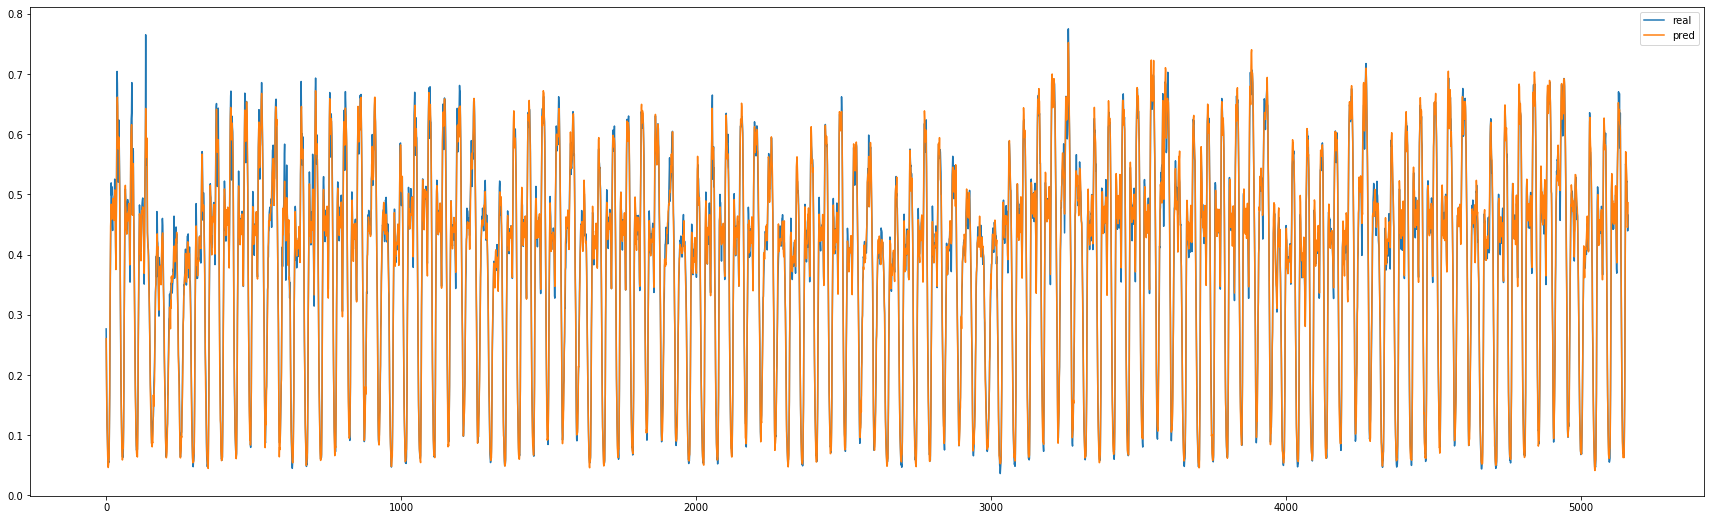

MSE : 0.00029


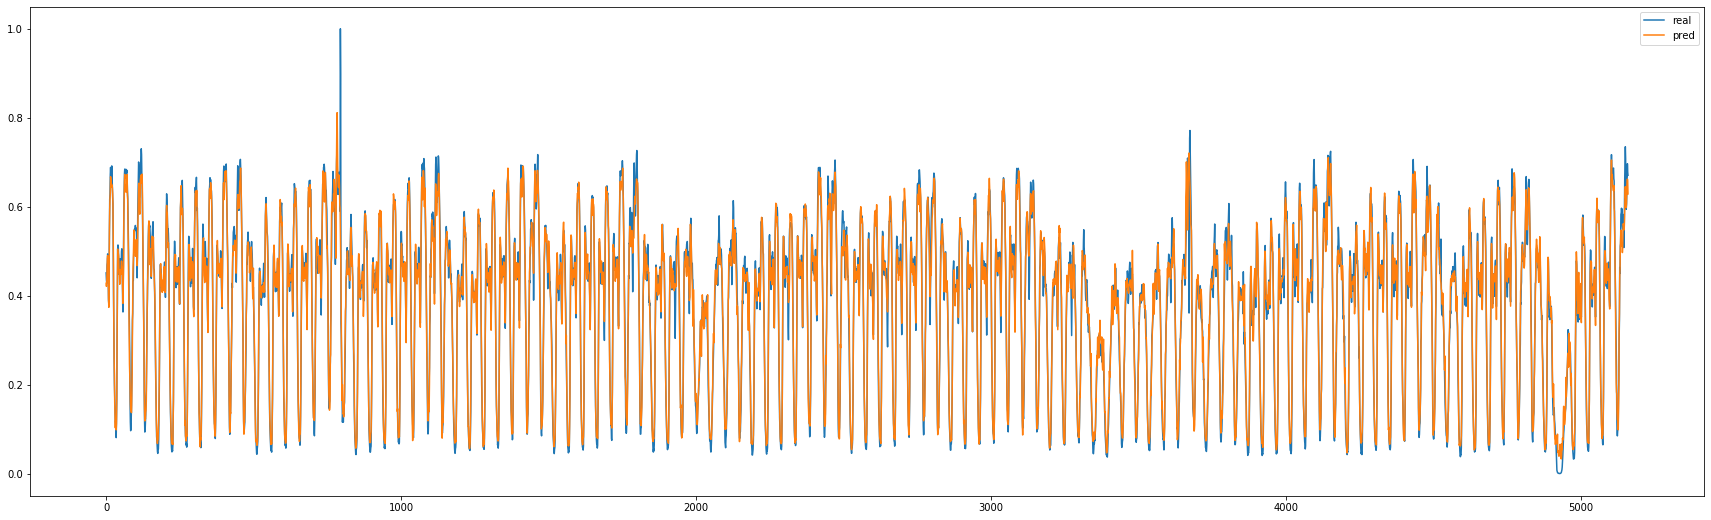

MSE : 0.00084


In [8]:
plot_train_test_reconstructions(model, X_train_tensor, X_train_data, X_test_tensor,X_test_data)


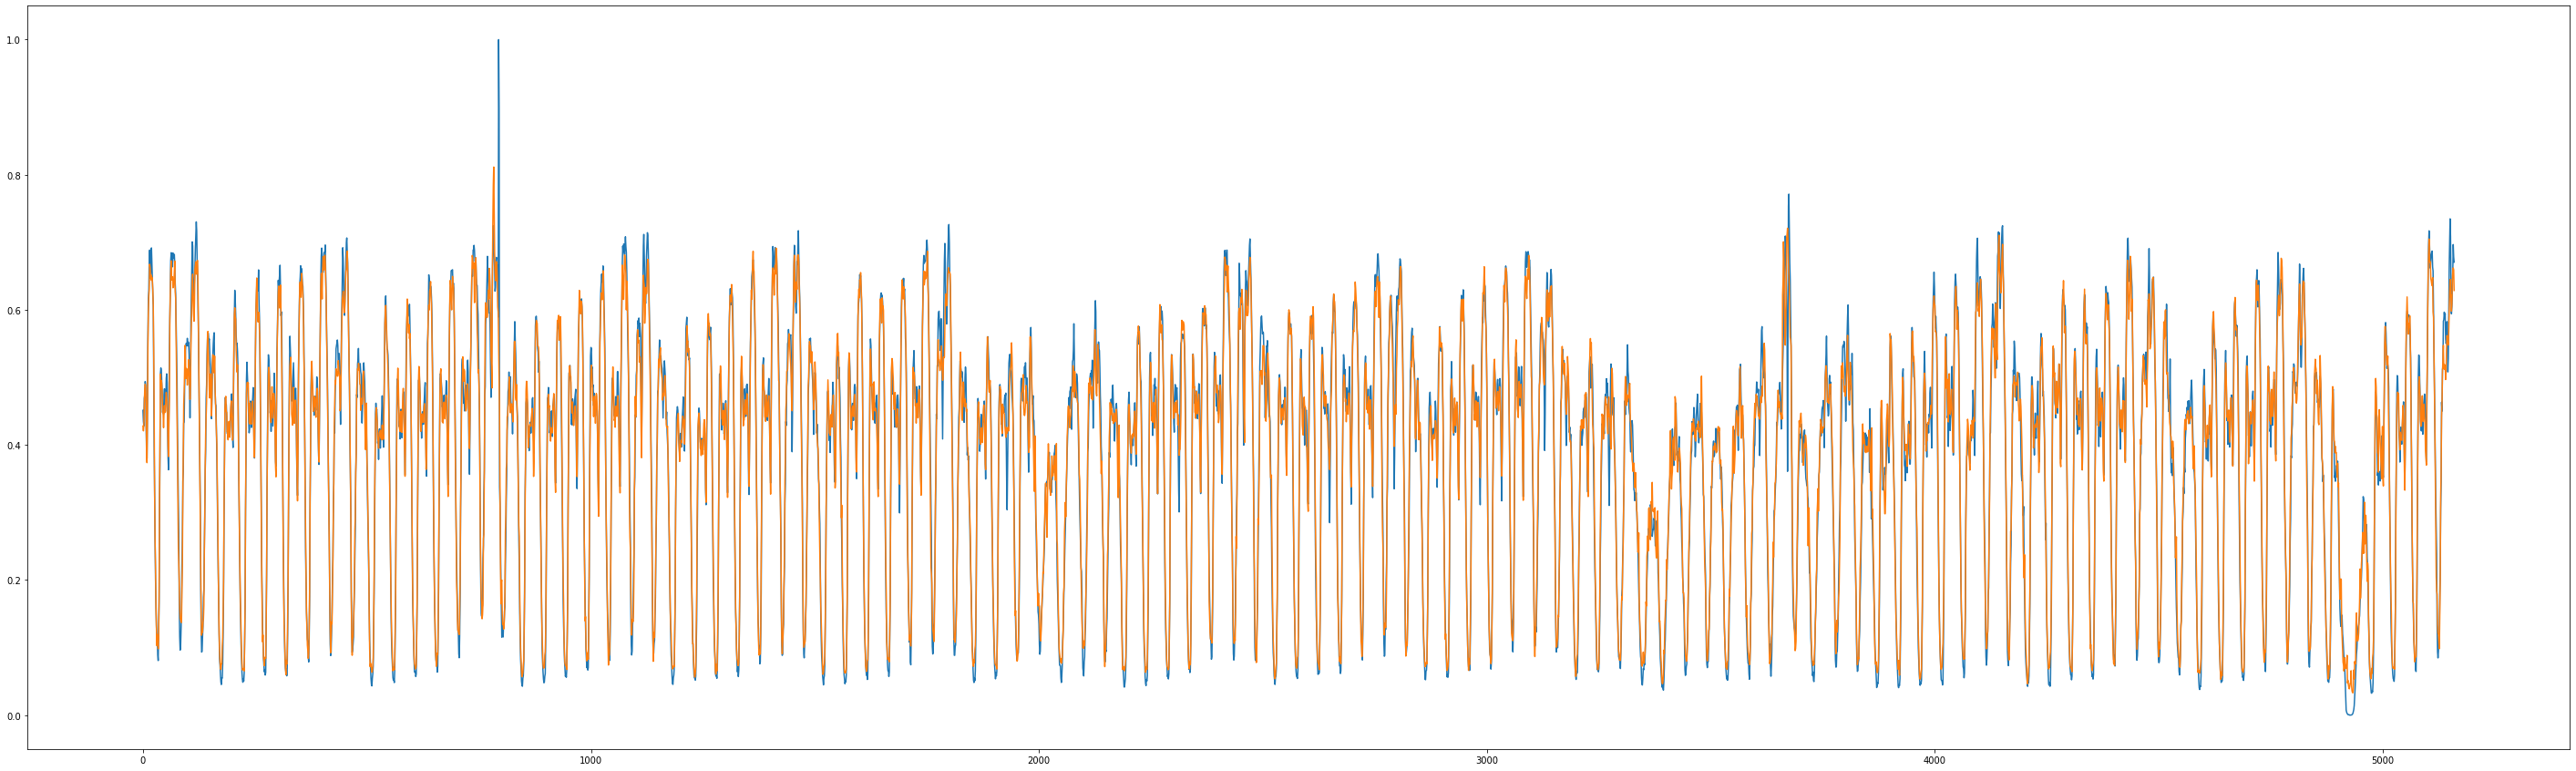

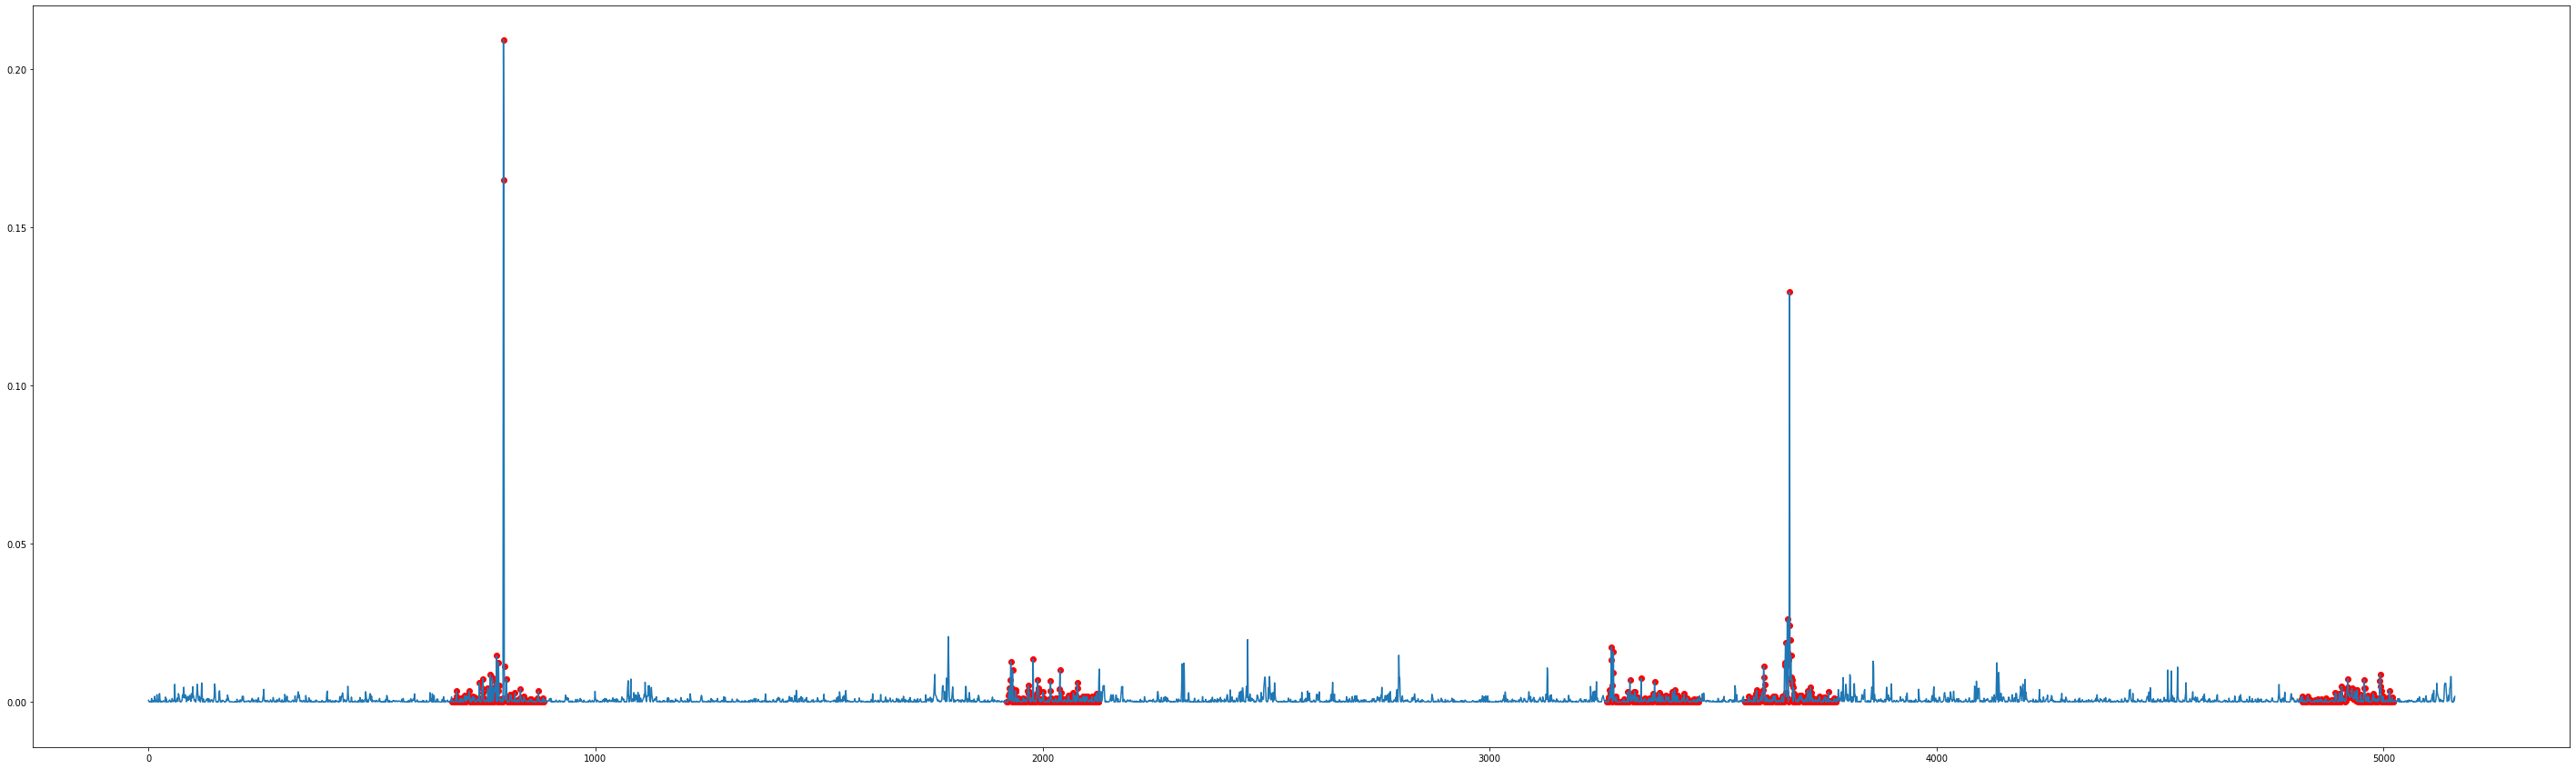

precision : 0.9475620975160993 recall : 1.0 f1 : 0.9730751062824753
aupr : 0.28193537856170736


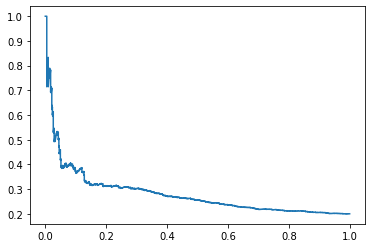

In [9]:
evaluation_utils.VAE_test_evaluation(model, X_test_tensor, X_test_data, X_train_data, anomaly_idxs)
